### A2: Bias in data
For this assignment, you will identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases.

Crowdworkers labelled these posts for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy.

The annotated datasets can be found [here](https://figshare.com/projects/Wikipedia_Talk/16731)

Executing each cell **sequentially** (Shift + Enter)  or use **Kernel >> Restart & Run all**

#### Step 1: Download the necessary data

For the purpose of this analysis please download the "toxicity" dataset with the following files:

1. **toxicity_annotated_comments.tsv** - The comment text and metadata for comments with toxicity labels generated by crowd-workers. The actual labels are in the corresponding toxicity_annotations.tsv since each comment was labeled multiple times

2. **toxicity_annotations.tsv** - Toxicity labels from several crowd-workers for each comment in toxicity_annotated_comments.tsv. It can be joined with toxicity_annotated_comments.tsv on rev_id

3. **toxicity_worker_demographics.tsv** - Demographic information about the crowdworkers. This information was obtained by an optional demographic survey administered after the labelling task. It is meant to be joined with toxicity_annotations.tsv on worker_id. Some fields may be blank if left unanswered
<br />

For more information about the data and schema please refer to the [page](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release#Toxicity)

#### Step 2: Load neccessary packages

For the purpose of fetching data, processing and analyzing it, we require the following packages:
1. [numpy](https://requests.readthedocs.io/en/master/user/install/) - Enables python code to run mathematical expressions on data
2. [wordcloud](https://pypi.org/project/wordcloud/) - Enables python code to generate word cloud based on the data
3. [nltk](https://www.nltk.org/install.html) - Enables python code to execute multiple function on textual data
4. [pandas](https://pandas.pydata.org/docs/getting_started/install.html) - Enables python code to load data from csv files and perform necessary data processing
5. [matplotlib](https://matplotlib.org/users/installing.html) - Enables python code to create visualizations and graphs
6. re - Enables python code to run regular expression based function

In [36]:
## Load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize

#### Step 3: Load the necessary data

Use pandas **read_csv** function to read the above specicified text files

In [2]:
comments = pd.read_csv('./data/toxicity_annotated_comments.tsv', sep = '\t')
annotations = pd.read_csv('./data/toxicity_annotations.tsv', sep = '\t')
workers = pd.read_csv('./data/toxicity_worker_demographics.tsv', sep = '\t')

print(workers.dtypes)

worker_id                  int64
gender                    object
english_first_language     int64
age_group                 object
education                 object
dtype: object


#### Step 4: Fill the null values

The workers demographic files had few null (blank values) in the data. <br />
We use **fillna(*Value to fill with*)** to fill the null values

In [3]:
workers['age_group'] = workers['age_group'].fillna('None')

#### Step 5: Check the demograhics

The next step is to understand the distribution of different worker demographics. We check for **Gender**, **Age Group** and **Education**

We use the **plot** function with parameter **kind = 'bar'** to plot bar graph

#### Gender

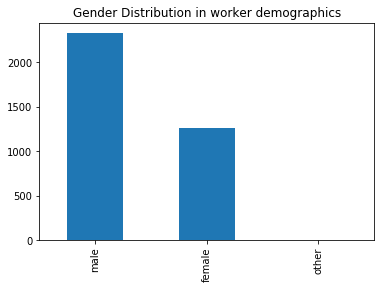

In [77]:
## worker gender bar graph
workers['gender'].value_counts().plot(kind = 'bar', title = 'Gender Distribution in worker demographics')

* The number of male workers are more than the number of female members. 
* The number of workers with "other" as gender are significantly lower than male and female

The gender of workers have skewness in them. Such skewness can lead to bias in the annotations as a few reviews might never go through a women and many review will never be annotated by anyone with "other" as the gender

#### Age Group

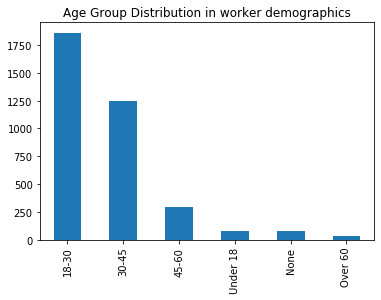

In [78]:
## Worker Age Group Bar Graph
workers['age_group'].value_counts().plot(kind = 'bar', title = 'Age Group Distribution in worker demographics')

* The age group 18-30 dominates the distribution of ages for workers
* The second is the age group 30-45 but is comparitively lesser than the 18-30 age group
* The other age groups are significantly lower than the above mentioned age groups 

There is a skew in the data present here. Such skew can be the source of bias, as we require similar number people from different age groups to perform unbiased annotation. <br />
Due to this skewness there is a chance that some of the reviews were predominantly marked by the age group 18-30 or 30-45 and never reached the other age groups. Therefore, those labels can be biased.

#### Education

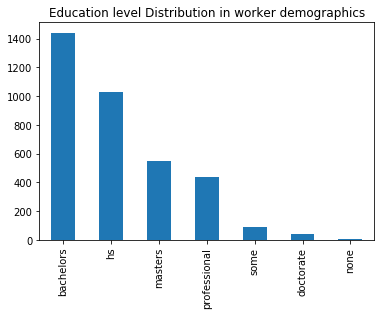

In [79]:
## Worker Education Bar Graph
workers['education'].value_counts().plot(kind = 'bar', title = 'Education level Distribution in worker demographics')

* The maximum number of people have a bacheors education 
* The second largest category of education is High School
* The masters and professional category are the next two categories in order

The case for education is better than age-group since the difference between the number of workers in first 4 largest categories are not very large (still the difference is significant). <br />
In this case as well the categories some, doctorate and none might not get a chance label a review, hence the annotations can be biased in this case as well

#### Total number of toxic reviews by each worker

We use aggregation on ***worker_id*** to sum the total number of toxic comments. Since the column **toxicity** has 1 for toxic reviews, summing the column would give us total number of toxic comments  

In [7]:
## Counting the number of reviews marked toxic (toxicity > 0) by workers
annotations.groupby('worker_id')['toxicity'].sum()

worker_id
0        77
1         5
2        37
3        42
4       135
       ... 
4296      4
4297      1
4298      5
4299      4
4300      0
Name: toxicity, Length: 4301, dtype: int64

#### Total number of reviews by each worker

We use aggregation on ***worker_id*** to count the total number of comments annoted by worker.

In [37]:
## Total reviews annotated by each worker
annotations.groupby('worker_id')['toxicity'].count()

worker_id
0       479
1        45
2       476
3       367
4       475
       ... 
4296     27
4297      9
4298     44
4299     16
4300      5
Name: toxicity, Length: 4301, dtype: int64

#### Step 6: Worker Toxic Reviews

Create a dataframe with total reviews by each worker and total toxic reviews by each workers using aggregation on the annotations data

We use the column ***toxicity*** as it contains values in the range of {0,1} where:
* 1 - represents toxic comment according to worker
* 0 - represents non toxic comment accordin to worker

Column Descriptions: 
* TotalComments - All reviews annotated by a worker
* ToxicComments - All toxic reviews annotated by a worker

In [9]:
## Create new dataframe for Toxic and Total comments by each worker
workerToxic = pd.DataFrame({'TotalComments' : annotations.groupby('worker_id')['toxicity'].count(), 'ToxicComments': annotations.groupby('worker_id')['toxicity'].sum()}).reset_index()

#### Calculate number of non toxic comments by each worker

***Non Toxic Comments = Total Comments - Toxic Comments*** 

In [10]:
## Counting number of non Toxic Comments marked by each worker
workerToxic['NonToxicComments'] = workerToxic['TotalComments'] - workerToxic['ToxicComments']

#### Step 7: Combine worker toxic reviews and demographics

Combine the dataframe **workToxic** with the worker demograhics to explore how different demograhpics react to toxicity in the comments

* Method - Left Join
* Key - ***worker_id***

***Note*** - *the number of workers in demographics data and annotation data are different*

In [11]:
## Joining the demographics to check how the distributions changes
workerToxicDemo = pd.merge(workerToxic, workers, on=['worker_id'], how = 'left')

#### Fill the null or blank values in each of the columns

Use the pandas function **fillna(Value to fill with)** to fill the null values of the demographic information of workers

In [13]:
## Fill the null values based on the data types of colums
## For string columns we use 'None', for integer columns we use 2

workerToxicDemo['gender'] = workerToxicDemo['gender'].fillna('None')
workerToxicDemo['english_first_language'] = workerToxicDemo['english_first_language'].fillna(2)
workerToxicDemo['age_group'] = workerToxicDemo['age_group'].fillna('None')
workerToxicDemo['education'] = workerToxicDemo['education'].fillna('No Education')

In [14]:
workerToxicDemo

,worker_id,TotalComments,ToxicComments,NonToxicComments,gender,english_first_language,age_group,education
0,0,479,77,402,male,0.0,30-45,professional
1,1,45,5,40,male,0.0,18-30,hs
2,2,476,37,439,None,2.0,None,No Education
3,3,367,42,325,female,0.0,18-30,bachelors
4,4,475,135,340,None,2.0,None,No Education
...,...,...,...,...,...,...,...,...
4296,4296,27,4,23,male,0.0,30-45,bachelors
4297,4297,9,1,8,male,1.0,Over 60,professional
4298,4298,44,5,39,female,1.0,18-30,hs
4299,4299,16,4,12,male,0.0,18-30,hs


#### Step 8: Check distribution of demographics

After joining the two datasets we have some new workers and new values in the demographic columns, hence it is important to see whether the skewness in data exist or not

#### Gender Distribution

* None - No information available

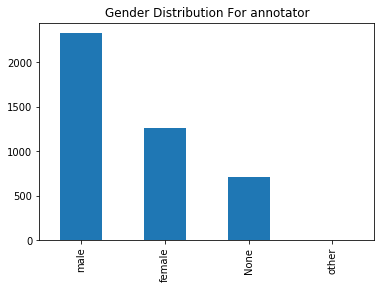

In [80]:
## Annotators Gender Bar Graph
workerToxicDemo['gender'].value_counts().plot(kind = 'bar', title = 'Gender Distribution For annotator')

The skewness still exist in the data, as male are the dominant category in the gender column. Hence, the distribution of gender can still lead to bias

#### First Language  (English or not)

* 0 - English is not the first language
* 1 - English is the first language
* 2 - No information available

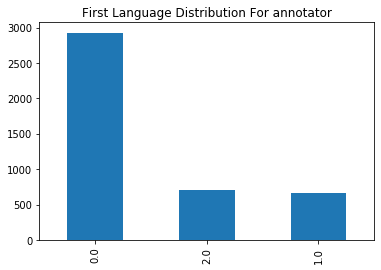

In [81]:
## Annotators Language Bar Graph
workerToxicDemo['english_first_language'].value_counts().plot(kind = 'bar', title = 'First Language Distribution For annotator')

The skewness still exists in the data, as workers with english not being the their first language are the dominant category in the english_first_language column. Hence, the distribution of english_first_language can still lead to bias

#### Age Group

* None - No information available

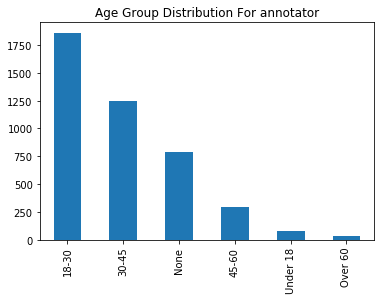

In [82]:
## Annotators Age Group Bar Graph
workerToxicDemo['age_group'].value_counts().plot(kind = 'bar', title = 'Age Group Distribution For annotator')

The skewness still exist in the data, as the age grouo 18-30 and 30-45 are the dominant category in the age group column. Also, None cannot be considered a trusted category as people from None category belong to either of other categories. Hence, the distribution of age group can still lead to bias

#### Step 9: Checking Toxicity for different demographics

Now we understand the distributions of different demographics and how they might induce some kind of bias in the data.
The next step is to check how these different demographics relate with the annotations of toxicity.

Therefore for demographics of workers like **Gender**, **Age Group**, **First Language** and **Education**, we calculate the ratio (**ToxicityRatio**) as the number of toxic comments to the number of total comments

#### Gender

Create a dataframe with total comments and total toxic comments for each ***gender*** value. Calculate the toxicity ratio by using the above specified definition

Column Description:
* Total Comments - Total Comments annotated by a gender
* Toxic Comments - Total Toxic Comments annotated by a gender
* Toxicity Ratio - Toxic Comments/ Total Comments

In [22]:
## Create new dataframe for Toxic and Total comments by each gender
print(workerToxicDemo.groupby('gender')['TotalComments'].sum())
workerToxicGender = pd.DataFrame({'TotalComments' : workerToxicDemo.groupby('gender')['TotalComments'].sum(), 'ToxicComments': workerToxicDemo.groupby('gender')['ToxicComments'].sum()}).reset_index()
workerToxicGender['ToxicityRatio'] = workerToxicGender['ToxicComments']/workerToxicGender['TotalComments']
workerToxicGender

gender
None      251334
female    457346
male      889251
other        358
Name: TotalComments, dtype: int64


,gender,TotalComments,ToxicComments,ToxicityRatio
0,None,251334,35756,0.142265
1,female,457346,71846,0.157093
2,male,889251,124394,0.139886
3,other,358,59,0.164804


#### Plot the number of toxic comments and toxicity ratio for each gender

Use the plot function with appropriate parameters of color and marker to describe both total toxic comments and toxicity ratio

Description:
* Total Toxic Comments - Bar graph
* Toxicity Ratio - Line Graph


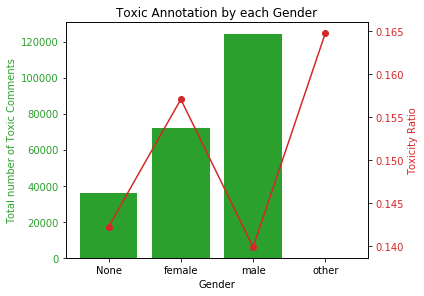

In [83]:
## Create a bar and line graph in a single plot
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Gender')
ax1.set_ylabel('Total number of Toxic Comments', color=color)
ax1.bar(workerToxicGender['gender'],workerToxicGender['ToxicComments'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Toxicity Ratio', color=color)
ax2.plot(workerToxicGender['gender'], workerToxicGender['ToxicityRatio'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Toxic Annotation by each Gender')
plt.show()

#### Obeservation 

Based on the plot we can see that the male marks the most number of comments as toxic. Now under normal circumstances we might assume that male are the gender category annotating most comments as toxic but if we look at the **Toxicity Ratio** we see that male has the lowest value.

Similarly, the gender category other has the highest toxicity ratio but has annotated only very few reviews.

Female gender on the other side has annotated a large number of reviews and also have significantly larger toxicity ratio.

Due the mismatch in the toxicity ratio, the probability of a review being marked as toxic increases when its reviewed by other or female, whereas the probability of review being marked as toxic decreases for male 

#### Age Group

Create a dataframe with total comments and total toxic comments for each ***age_group*** value. Calculate the toxicity ratio by using the above specified definition

Column Description:
* Total Comments - Total Comments annotated by a age group
* Toxic Comments - Total Toxic Comments annotated by a age group
* Toxicity Ratio - Toxic Comments/ Total Comments

In [68]:
## Create new dataframe for Toxic and Total comments by each Age group
print(workerToxicDemo.groupby('age_group')['TotalComments'].sum())
workerToxicAge = pd.DataFrame({'TotalComments' : workerToxicDemo.groupby('age_group')['TotalComments'].sum(), 'ToxicComments': workerToxicDemo.groupby('age_group')['ToxicComments'].sum()}).reset_index()
workerToxicAge['ToxicityRatio'] = workerToxicAge['ToxicComments']/workerToxicAge['TotalComments']
workerToxicAge

age_group
18-30       708182
30-45       468455
45-60       103127
None        280648
Over 60       9717
Under 18     28160
Name: TotalComments, dtype: int64


,age_group,TotalComments,ToxicComments,ToxicityRatio
0,18-30,708182,99976,0.141173
1,30-45,468455,69997,0.149421
2,45-60,103127,17145,0.166251
3,None,280648,40029,0.142631
4,Over 60,9717,1525,0.156941
5,Under 18,28160,3383,0.120135


#### Plot the number of toxic comments and toxicity ratio for each age group

Use the plot function with appropriate parameters of color and marker to describe both total toxic comments and toxicity ratio

Description:
* Total Toxic Comments - Bar graph
* Toxicity Ratio - Line Graph


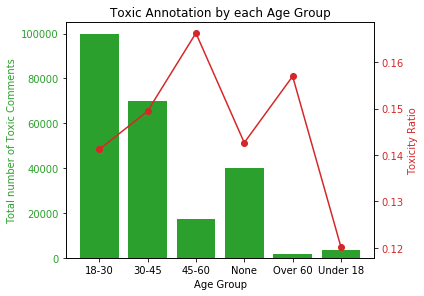

In [84]:
## Create a bar and line graph in a single plot
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Total number of Toxic Comments', color=color)
ax1.bar(workerToxicAge['age_group'],workerToxicAge['ToxicComments'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Toxicity Ratio', color=color)
ax2.plot(workerToxicAge['age_group'], workerToxicAge['ToxicityRatio'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Toxic Annotation by each Age Group')
plt.show()

#### Observation

Based on the plot we can see that the 18-30 age group marks the most number of comments as toxic but its Toxicity Ratio is less than almost all the categories.

The age group 45-60 and Over 60 show relatively higher levels of Toxicity Ratio

Due the mismatch in the toxicity ratio, the probability of a review being marked as toxic increases when its reviewed by someone in the age group of 45-60 or Over 60, whereas the probability of review being marked as toxic decreases when reviewed by someone with age Under 18 or between 18-30

#### Education

Create a dataframe with total comments and total toxic comments for each ***education*** value. Calculate the toxicity ratio by using the above specified definition

Column Description:
* Total Comments - Total Comments annotated by a education
* Toxic Comments - Total Toxic Comments annotated by a education
* Toxicity Ratio - Toxic Comments/ Total Comments

In [24]:
## Create new dataframe for Toxic and Total comments by each Education
print(workerToxicDemo.groupby('education')['TotalComments'].sum())
workerToxicEducation = pd.DataFrame({'TotalComments' : workerToxicDemo.groupby('education')['TotalComments'].sum(), 'ToxicComments': workerToxicDemo.groupby('education')['ToxicComments'].sum()}).reset_index()
workerToxicEducation['ToxicityRatio'] = workerToxicEducation['ToxicComments']/workerToxicEducation['TotalComments']
workerToxicEducation

education
No Education    251334
bachelors       540213
doctorate        14583
hs              381511
masters         205425
none               925
professional    168456
some             35842
Name: TotalComments, dtype: int64


,education,TotalComments,ToxicComments,ToxicityRatio
0,No Education,251334,35756,0.142265
1,bachelors,540213,80718,0.149419
2,doctorate,14583,1908,0.130837
3,hs,381511,54382,0.142544
4,masters,205425,30281,0.147407
5,none,925,122,0.131892
6,professional,168456,24106,0.143100
7,some,35842,4782,0.133419


#### Plot the number of toxic comments and toxicity ratio for each educations level

Use the plot function with appropriate parameters of color and marker to describe both total toxic comments and toxicity ratio

Description:
* Total Toxic Comments - Bar graph
* Toxicity Ratio - Line Graph

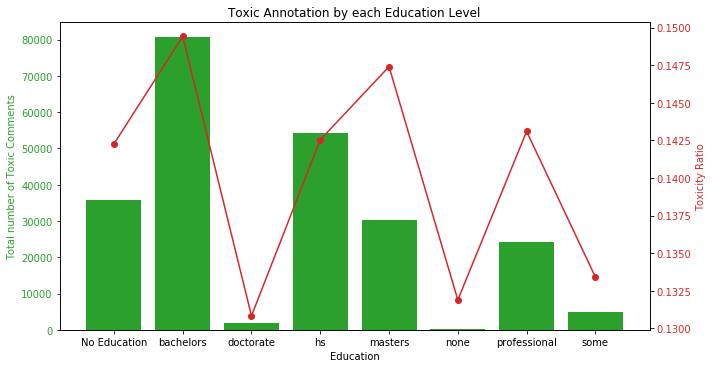

<Figure size 720x720 with 0 Axes>

In [87]:
## Create a bar and line graph in a single plot
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:green'
ax1.set_xlabel('Education')
ax1.set_ylabel('Total number of Toxic Comments', color=color)
ax1.bar(workerToxicEducation['education'],workerToxicEducation['ToxicComments'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Toxicity Ratio', color=color)
ax2.plot(workerToxicEducation['education'], workerToxicEducation['ToxicityRatio'], color=color,marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Toxic Annotation by each Education Level')
plt.figure(figsize=(10,10))
plt.show()

#### Observation

Based on the plot we can see that workers with bachelors education have annotated maximum comments as toxic and with the highest toxicity ratio. 

Workers with masters education have annoted relatively lesser reviews as toxic but with high toxicity ratio 

Due the mismatch in the toxicity ratio, the probability of a review being marked as toxic increases when its reviewed by someone with the education of bachelors or masters


#### First Language (English)

Create a dataframe with total comments and total toxic comments for each ***english_first_language*** value. Calculate the toxicity ratio by using the above specified definition

Column Description:
* Total Comments - Total Comments annotated by a first language
* Toxic Comments - Total Toxic Comments annotated by a first language
* Toxicity Ratio - Toxic Comments/ Total Comments

In [25]:
## Create new dataframe for Toxic and Total comments by each Language
print(workerToxicDemo.groupby('english_first_language')['TotalComments'].sum())
workerToxicEnglish = pd.DataFrame({'TotalComments' : workerToxicDemo.groupby('english_first_language')['TotalComments'].sum(), 'ToxicComments': workerToxicDemo.groupby('english_first_language')['ToxicComments'].sum()}).reset_index()
workerToxicEnglish['ToxicityRatio'] = workerToxicEnglish['ToxicComments']/workerToxicEnglish['TotalComments']
workerToxicEnglish

english_first_language
0.0    1113162
1.0     233793
2.0     251334
Name: TotalComments, dtype: int64


,english_first_language,TotalComments,ToxicComments,ToxicityRatio
0,0.0,1113162,160714,0.144376
1,1.0,233793,35585,0.152207
2,2.0,251334,35756,0.142265


#### Plot the number of toxic comments and toxicity ratio for each first language

Use the plot function with appropriate parameters of color and marker to describe both total toxic comments and toxicity ratio

Description:
* Total Toxic Comments - Bar graph
* Toxicity Ratio - Line Graph

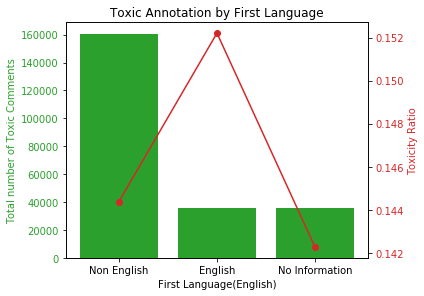

In [91]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('First Language(English)')
ax1.set_ylabel('Total number of Toxic Comments', color=color)
ax1.bar(workerToxicEnglish['english_first_language'],workerToxicEnglish['ToxicComments'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Toxicity Ratio', color=color)
ax2.plot(workerToxicEnglish['english_first_language'], workerToxicEnglish['ToxicityRatio'], color=color,marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Toxic Annotation by First Language')
plt.xticks(ticks = [0,1,2], labels = ['Non English', 'English','No Information'])
plt.show()

#### Observation

Based on the plot we can see that workers with English not being their first language have annotated maximum comments as toxic and with the low toxicity ratio.

Workers with English as their first language have annoted relatively lesser reviews as toxic but with high toxicity ratio

Due the mismatch in the toxicity ratio, the probability of a review being marked as toxic increases when its reviewed by someone with the English being their first language

### Analyze toxic words

#### Step 10: Determine toxicity of reviews

Since the toxicity column has values in the range {0,1}, we can use it to determine whether a review is toxic or not
We use the concept that if more than half of the annotators mark the review as toxic, we consider it toxic otherwise healthy

* Total Reviews: Calculated by counting the number of times a review was annotated
* SumReviews: Calculated how many annotators think the review is toxic

In [73]:
## Create a dataframe of all reviews
toxicReviews = pd.DataFrame({'TotalReviews' : annotations.groupby('rev_id')['toxicity'].count(), 'SumReviews': annotations.groupby('rev_id')['toxicity'].sum()}).reset_index()
toxicReviews

,rev_id,TotalReviews,SumReviews
0,2232.0,10,1
1,4216.0,10,0
2,8953.0,10,0
3,26547.0,10,0
4,28959.0,10,2
...,...,...,...
159681,699848324.0,10,0
159682,699851288.0,10,0
159683,699857133.0,10,0
159684,699891012.0,10,4


#### Step 11: Generate Toxic Flag

If more than half annotators mark the review as toxic, we flag ***Is Toxic = 1 otherwise 0***

***IsToxic*** is calculated by checking if ***SumReviews >= TotalReviews/2***

In [93]:
## Criteria to decide whether a review is toxic or not
toxicReviews['IsToxic'] = toxicReviews.apply(lambda row: 1 if row['SumReviews'] >= row['TotalReviews']/2 else 0, axis = 1)

In [30]:
toxicReviews

,rev_id,TotalReviews,SumReviews,IsToxic
0,2232.0,10,1,0
1,4216.0,10,0,0
2,8953.0,10,0,0
3,26547.0,10,0,0
4,28959.0,10,2,0
...,...,...,...,...
159681,699848324.0,10,0,0
159682,699851288.0,10,0,0
159683,699857133.0,10,0,0
159684,699891012.0,10,4,0


#### Step 12: Get sentences for each review

Combine the comments dataframe and the above created dataframe to get a new dataframe such that we know whether each review is toxic or not

* Method: Left Join
* Key: ***rev_id***

In [31]:
## Join the data to get the actual reviews
taggedReviews = pd.merge(comments, toxicReviews, on = ['rev_id'], how = 'left')

#### Step 13: Clean the reviews

To determine the most common words amongst toxic reviews we need to remove the unecessary words, punctuations, stopwords and other symobols.


Replace the common word ***NEWLINE_TOKEN and NEWLINE_TOKENNEWLINE_TOKEN*** with empty space

In [32]:
taggedReviews['comment'] = taggedReviews['comment'].apply(lambda x: x.replace('NEWLINE_TOKEN','').replace('NEWLINE_TOKENNEWLINE_TOKEN', ''))

Function to remove special characters, symbols and extra white spaces. Create a list of stop words to remove from the sentences.

Removing the uneccesary words and characters allows the wordcloud algorithm to focus on important words, otherwise it will show common words like "the", "is", "are" etc as the most used words 


In [33]:
## Create stopword list
stopwordsList = set(stopwords.words(['english']))

## Start function to clean text
def featureEngineer(toxic_data):
    '''
        Use regular expressions to remove extra spaces and special characters
    '''
    toxic_data['comment'] = toxic_data['comment'].apply(lambda x: re.sub('\ |\!|\/|\;|\:|\=|\"|\:|\]|\[|\`|\<|\>|\{|\}|\'|\?|\.|\,|\|',' ', str(x)))
    toxic_data['comment'] = toxic_data['comment'].apply(lambda x: re.sub('\s+',' ',str(x).strip().lower()))
    return toxic_data

#### Step 14: Filter data

To get the common toxic words, we need to filter the dataframe for only toxic comments

* Filter for IsToxic == 1

In [34]:
## Call the review cleaning function for Toxic reviews
taggedReviews = featureEngineer(taggedReviews[taggedReviews['IsToxic'] == 1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Step 15: Generate visual for common words

We use word cloud to express the most common words in toxic comments.

Word Clouds visualizes common words in chart based on the frequency and represents them with different color and size

Parameter:
* stopwords - List of unecessary words not to consider while generating wordcloud

<Figure size 576x576 with 0 Axes>

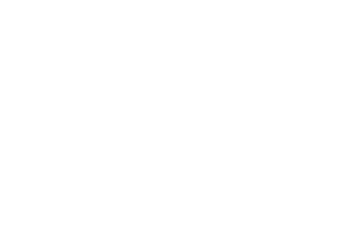

<Figure size 576x576 with 0 Axes>

In [92]:
## Since the image contains offensive langauge please run the code to check the output
text = " ".join(review for review in taggedReviews.comment)
wordcloud = WordCloud(stopwords=stopwordsList, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize = (8,8))
plt.show()

### Implications

#### Q1) Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

I think the models trained or the Perspective API would work great for the project ***Behave!***. The reason for choosing the project is based on the thought that any **toxic** review will most likely be annotated toxic by the maximum number of workers. Therefore, the chances of missing out any actual toxic reviews on ***Behave!*** becomes less.

Similarly, if a comment is certainly **healtly** to be viewed, then most of the workers will annotate it as healthy, hence the actual good review, subreddits or commments will still be visible. 

The only issue comes when we have a conflict in opinion, a 50-50 case. In such situations we actually don't know what do to, therefore its best to let the machine learning algorithm decide what the answer should be and then we can take viewers opinion to refine the models even more 

#### Q2) What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? 

I think sarcastic comments, indirect implications to ethinicity, race, caste or religion would be hard to recognize for the Perspective API.

#### Q3) Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

As a data scientis, I would try to understand the problem we want to solve. It is seen that NLP models work better if they are developed with a specific purpose. Therefore, I would modify the data or the labelling method (labels or the questions to select a label) in order to make the model learn more domain specific things.

Another thing would be to experiment with different models on a stratified sample of data to check which works best for our purpose. Its not always that more complicated or more advanced method would work the best on our data.

If the project budget allows, do a crowdsource annotation by another seperate company with required number of workers from different demographics. This will allow me to better understand the possible bias in the data and form strategies to minimize it